# If you want to predict IAP ONLY LTV: 
# WELCOME
Hello Guys,
This method is going to be best fit in predicting LTV IAP only games.
Especially working with limited data you're going to gain the maximum profit.
This is a guide to how to handle the variables, how do you make conclusions from the tables and charts.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arviz.labels import MapLabeller

from pymc_marketing import clv

In [2]:
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina" # nice looking plots

In [3]:
raw_trans = pd.read_csv("https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/datasets/cdnow_transactions.csv")

raw_trans.head(5)

,_id,id,date,cds_bought,spent
0,4,1,19970101,2,29.33
1,4,1,19970118,2,29.73
2,4,1,19970802,1,14.96
3,4,1,19971212,2,26.48
4,21,2,19970101,3,63.34


In [4]:
rfm_data = clv.utils.rfm_summary(
    raw_trans,
    customer_id_col = "id",
    datetime_col = "date",
    monetary_value_col = "spent",
    datetime_format = "%Y%m%d",
    time_unit = "W")

rfm_data

/opt/anaconda3/envs/marketing_env/lib/python3.11/site-packages/pymc_marketing/clv/utils.py:260: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<PeriodArray>
['1996-12-30/1997-01-05', '1997-01-13/1997-01-19', '1997-07-28/1997-08-03',
 '1997-12-08/1997-12-14', '1996-12-30/1997-01-05', '1997-01-13/1997-01-19',
 '1996-12-30/1997-01-05', '1996-12-30/1997-01-05', '1996-12-30/1997-01-05',
 '1996-12-30/1997-01-05',
 ...
 '1997-03-24/1997-03-30', '1998-01-26/1998-02-01', '1997-03-24/1997-03-30',
 '1997-06-09/1997-06-15', '1997-07-14/1997-07-20', '1997-07-21/1997-07-27',
 '1997-09-22/1997-09-28', '1997-12-29/1998-01-04', '1998-06-01/1998-06-07',
 '1997-03-24/1997-03-30']
Length: 6361, dtype: period[W-SUN]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  period_transactions.loc[:, datetime_col] = period_transactions[


,customer_id,frequency,recency,T,monetary_value
0,1,3.0,49.0,78.0,23.723333
1,2,1.0,2.0,78.0,11.770000
2,3,0.0,0.0,78.0,0.000000
3,4,0.0,0.0,78.0,0.000000
4,5,0.0,0.0,78.0,0.000000
...,...,...,...,...,...
2352,2353,2.0,53.0,66.0,19.775000
2353,2354,5.0,24.0,66.0,44.928000
2354,2355,1.0,44.0,66.0,24.600000
2355,2356,6.0,62.0,66.0,31.871667


To visualize data in RFM format, we can plot the recency and T of the customers with the "plot_customer_exposure" function.

<Axes: title={'center': 'Customer Exposure'}, xlabel='Time since first purchase', ylabel='Customer'>

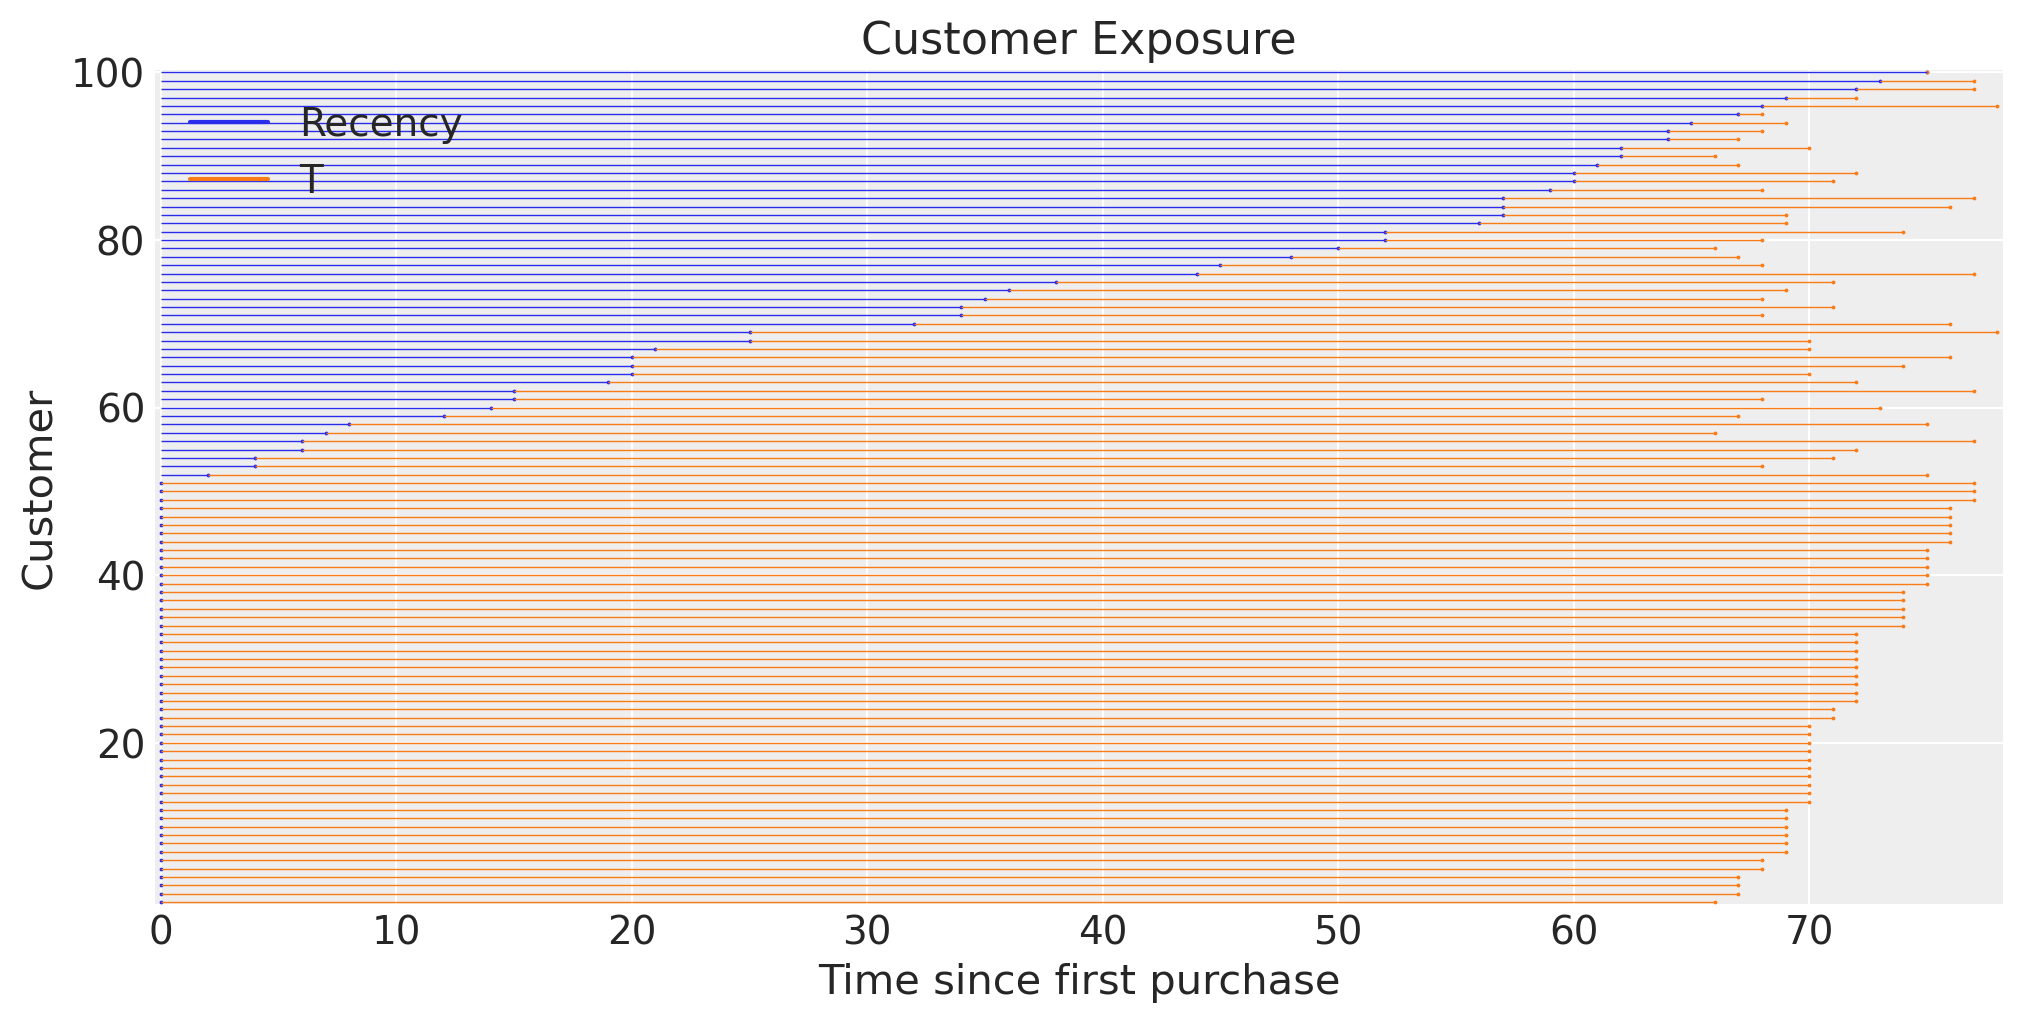

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    rfm_data
    .sample(n=100, random_state=42)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
)

We see a large chunk (>60%) of customers haven’t made another purchase in a while.

# Basic Frequency/Recency analysis using the BG/NBD model

As this dataset represents non-contractual transactions in the continuous time domain, we will use the Beta-Geometric/Negative Binomial Distribution (BG/NBD) model to infer the frequency of repeat purchases for each customer in the dataset. The Pareto/Negative Binomial Distribution (Pareto/NBD) model is also available as an alternative if you wish to compare results.

For use cases involving discrete time, contractual transactions, use the Shifted Beta-Geometric model.

In [6]:
bgm = clv.BetaGeoModel(
    data = rfm_data
)
bgm.build_model()

In [7]:
bgm

BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))

The default priors for the 4 parameters follow a HalfFlat distribution, which is an improper positive uniform distribution. For small datasets this prior can yield implausible posteriors. To avoid this problem, more informative priors can be specified by defining custom PyMC distributions.

Here, we will replace the HalfFlat default by more well-behaved HalfNormal priors with a standard deviation of 10. Customization priors is possible by passing a dictionary with keys being the name of the prior, and values being a dictionary with 2 keys: ‘dist’ representing the name of PyMC distribution and ‘kwargs’ that holds an optional dictionary of all parameters we wish to pass to the distribution

In [8]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
}

In [9]:
bgm = clv.BetaGeoModel(
    data = rfm_data,
    model_config = model_config,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfNormal(0, 10)
         b ~ HalfNormal(0, 10)
     alpha ~ HalfNormal(0, 10)
         r ~ HalfNormal(0, 10)
likelihood ~ Potential(f(r, alpha, b, a))

In [10]:
bgm.fit()
bgm.fit_summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.694,0.164,0.424,1.002,0.004,0.003,1790.0,1683.0,1.0
b,3.314,1.031,1.734,5.242,0.025,0.018,1817.0,1749.0,1.0
alpha,7.105,0.512,6.170,8.054,0.012,0.008,1936.0,2325.0,1.0
r,0.276,0.012,0.255,0.301,0.000,0.000,1843.0,1843.0,1.0


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'r'}>],
      dtype=object)

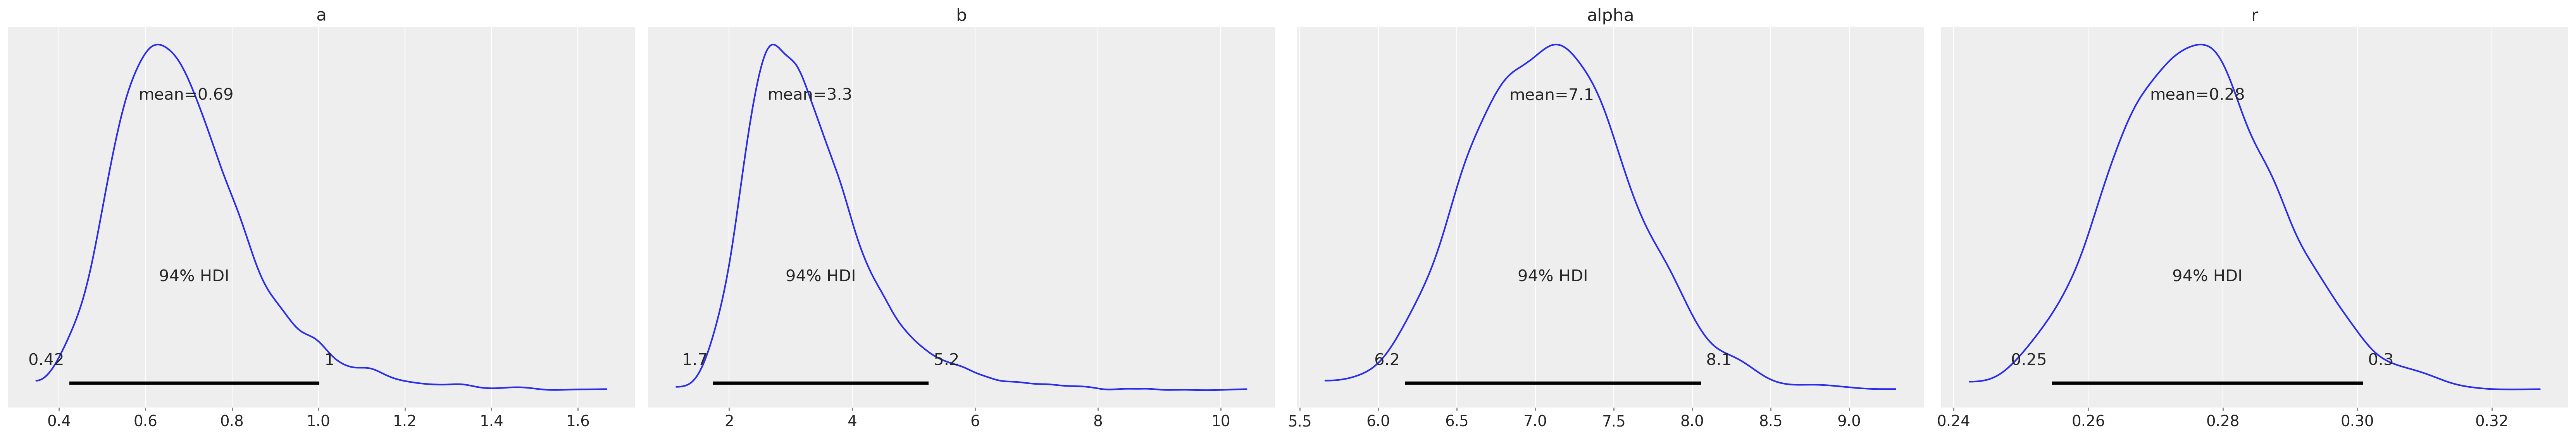

In [11]:
az.plot_posterior(bgm.fit_result)

# Visualizing the Frequency/Recency Matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

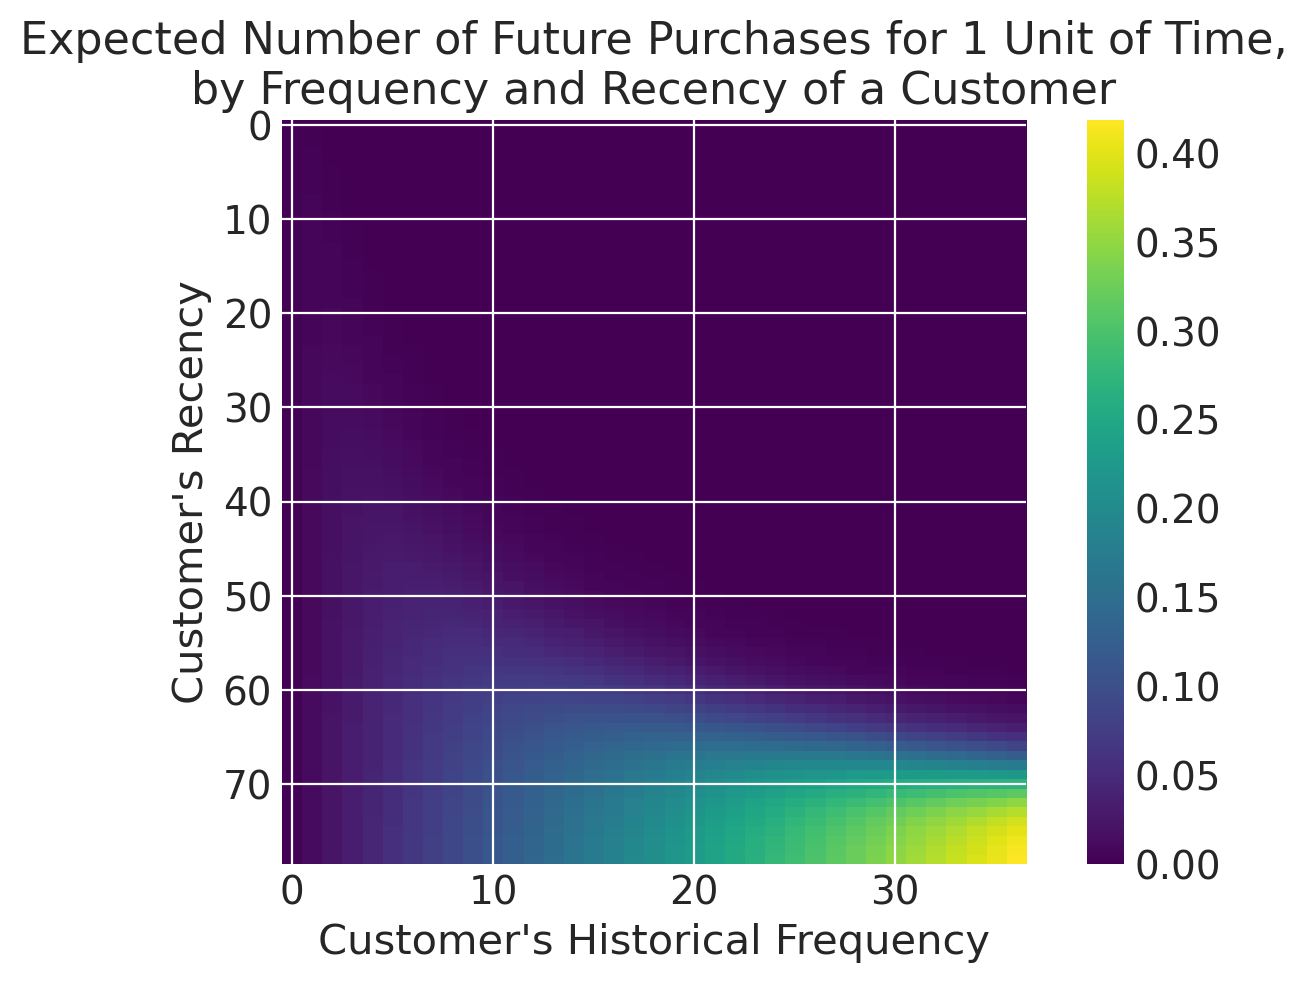

In [12]:
from lifetimes import BetaGeoFitter

# Assuming you have a dataframe 'df' with 'frequency' and 'recency' columns
bgm_lifetimes = BetaGeoFitter()
bgm_lifetimes.fit(rfm_data['frequency'], rfm_data['recency'], rfm_data['T'])

# After fitting the model, you would then plot the matrix
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgm_lifetimes)
#clv.plot_frequency_recency_matrix(bgm)

We can see our best customers have been active for over 60 weeks and have made over 20 purchases (bottom-right). Note the “tail” sweeping up towards the upper-left corner - these customers are infrequent and/or may not have purchased recently. What is the probability they are still active?

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

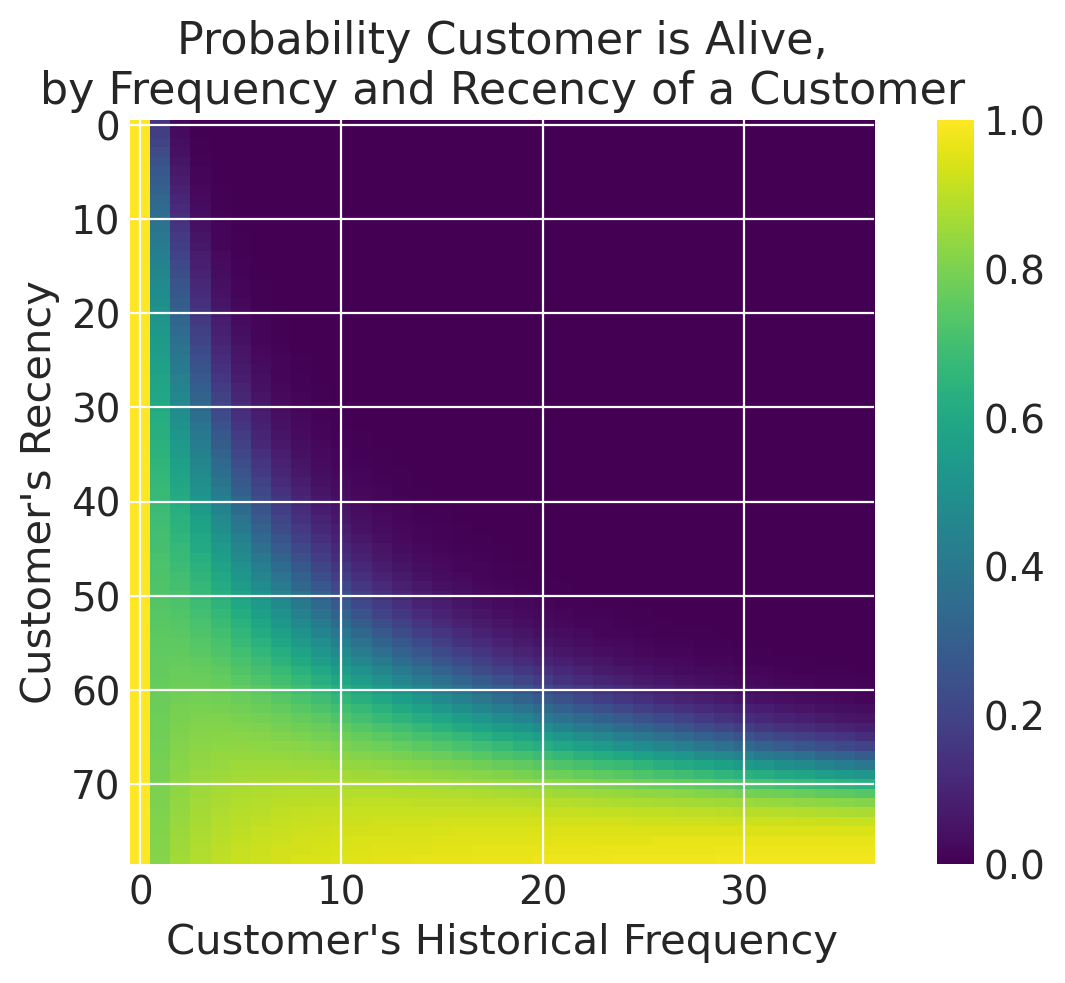

In [13]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgm_lifetimes)

Note that all non-repeat customers have an alive probability of 1, which is one of the quirks of BetaGeoModel. In many use cases this is still a valid assumption, but if non-repeat customers are a key focus in your use case, you may want to try ParetoNBDModel instead.

Looking at the probability alive matrix, we can infer that customers who have made fewer purchases are less likely to return, and may be worth targeting for retention.

# Ranking customers from best to worst

Having fit the model, we can ask what is the expected number of purchases for our customers in the next period. Let’s look at the four more promising customers.

In [14]:
num_purchases = bgm.expected_num_purchases(
    customer_id=rfm_data["customer_id"],
    t=1,
    frequency=rfm_data["frequency"],
    recency=rfm_data["recency"],
    T=rfm_data["T"]
)

In [15]:
sdata = rfm_data.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

,customer_id,frequency,recency,T,monetary_value,expected_purchases
812,813,30.0,72.0,74.0,35.654000,0.355716
1202,1203,32.0,71.0,72.0,47.172187,0.394456
156,157,36.0,74.0,77.0,30.603611,0.402670
1980,1981,35.0,66.0,68.0,46.748857,0.446363


We can plot the uncertainty in the expected number of purchases in the next period.



Text(0.5, 1.05, 'Expected number purchases in the next period')

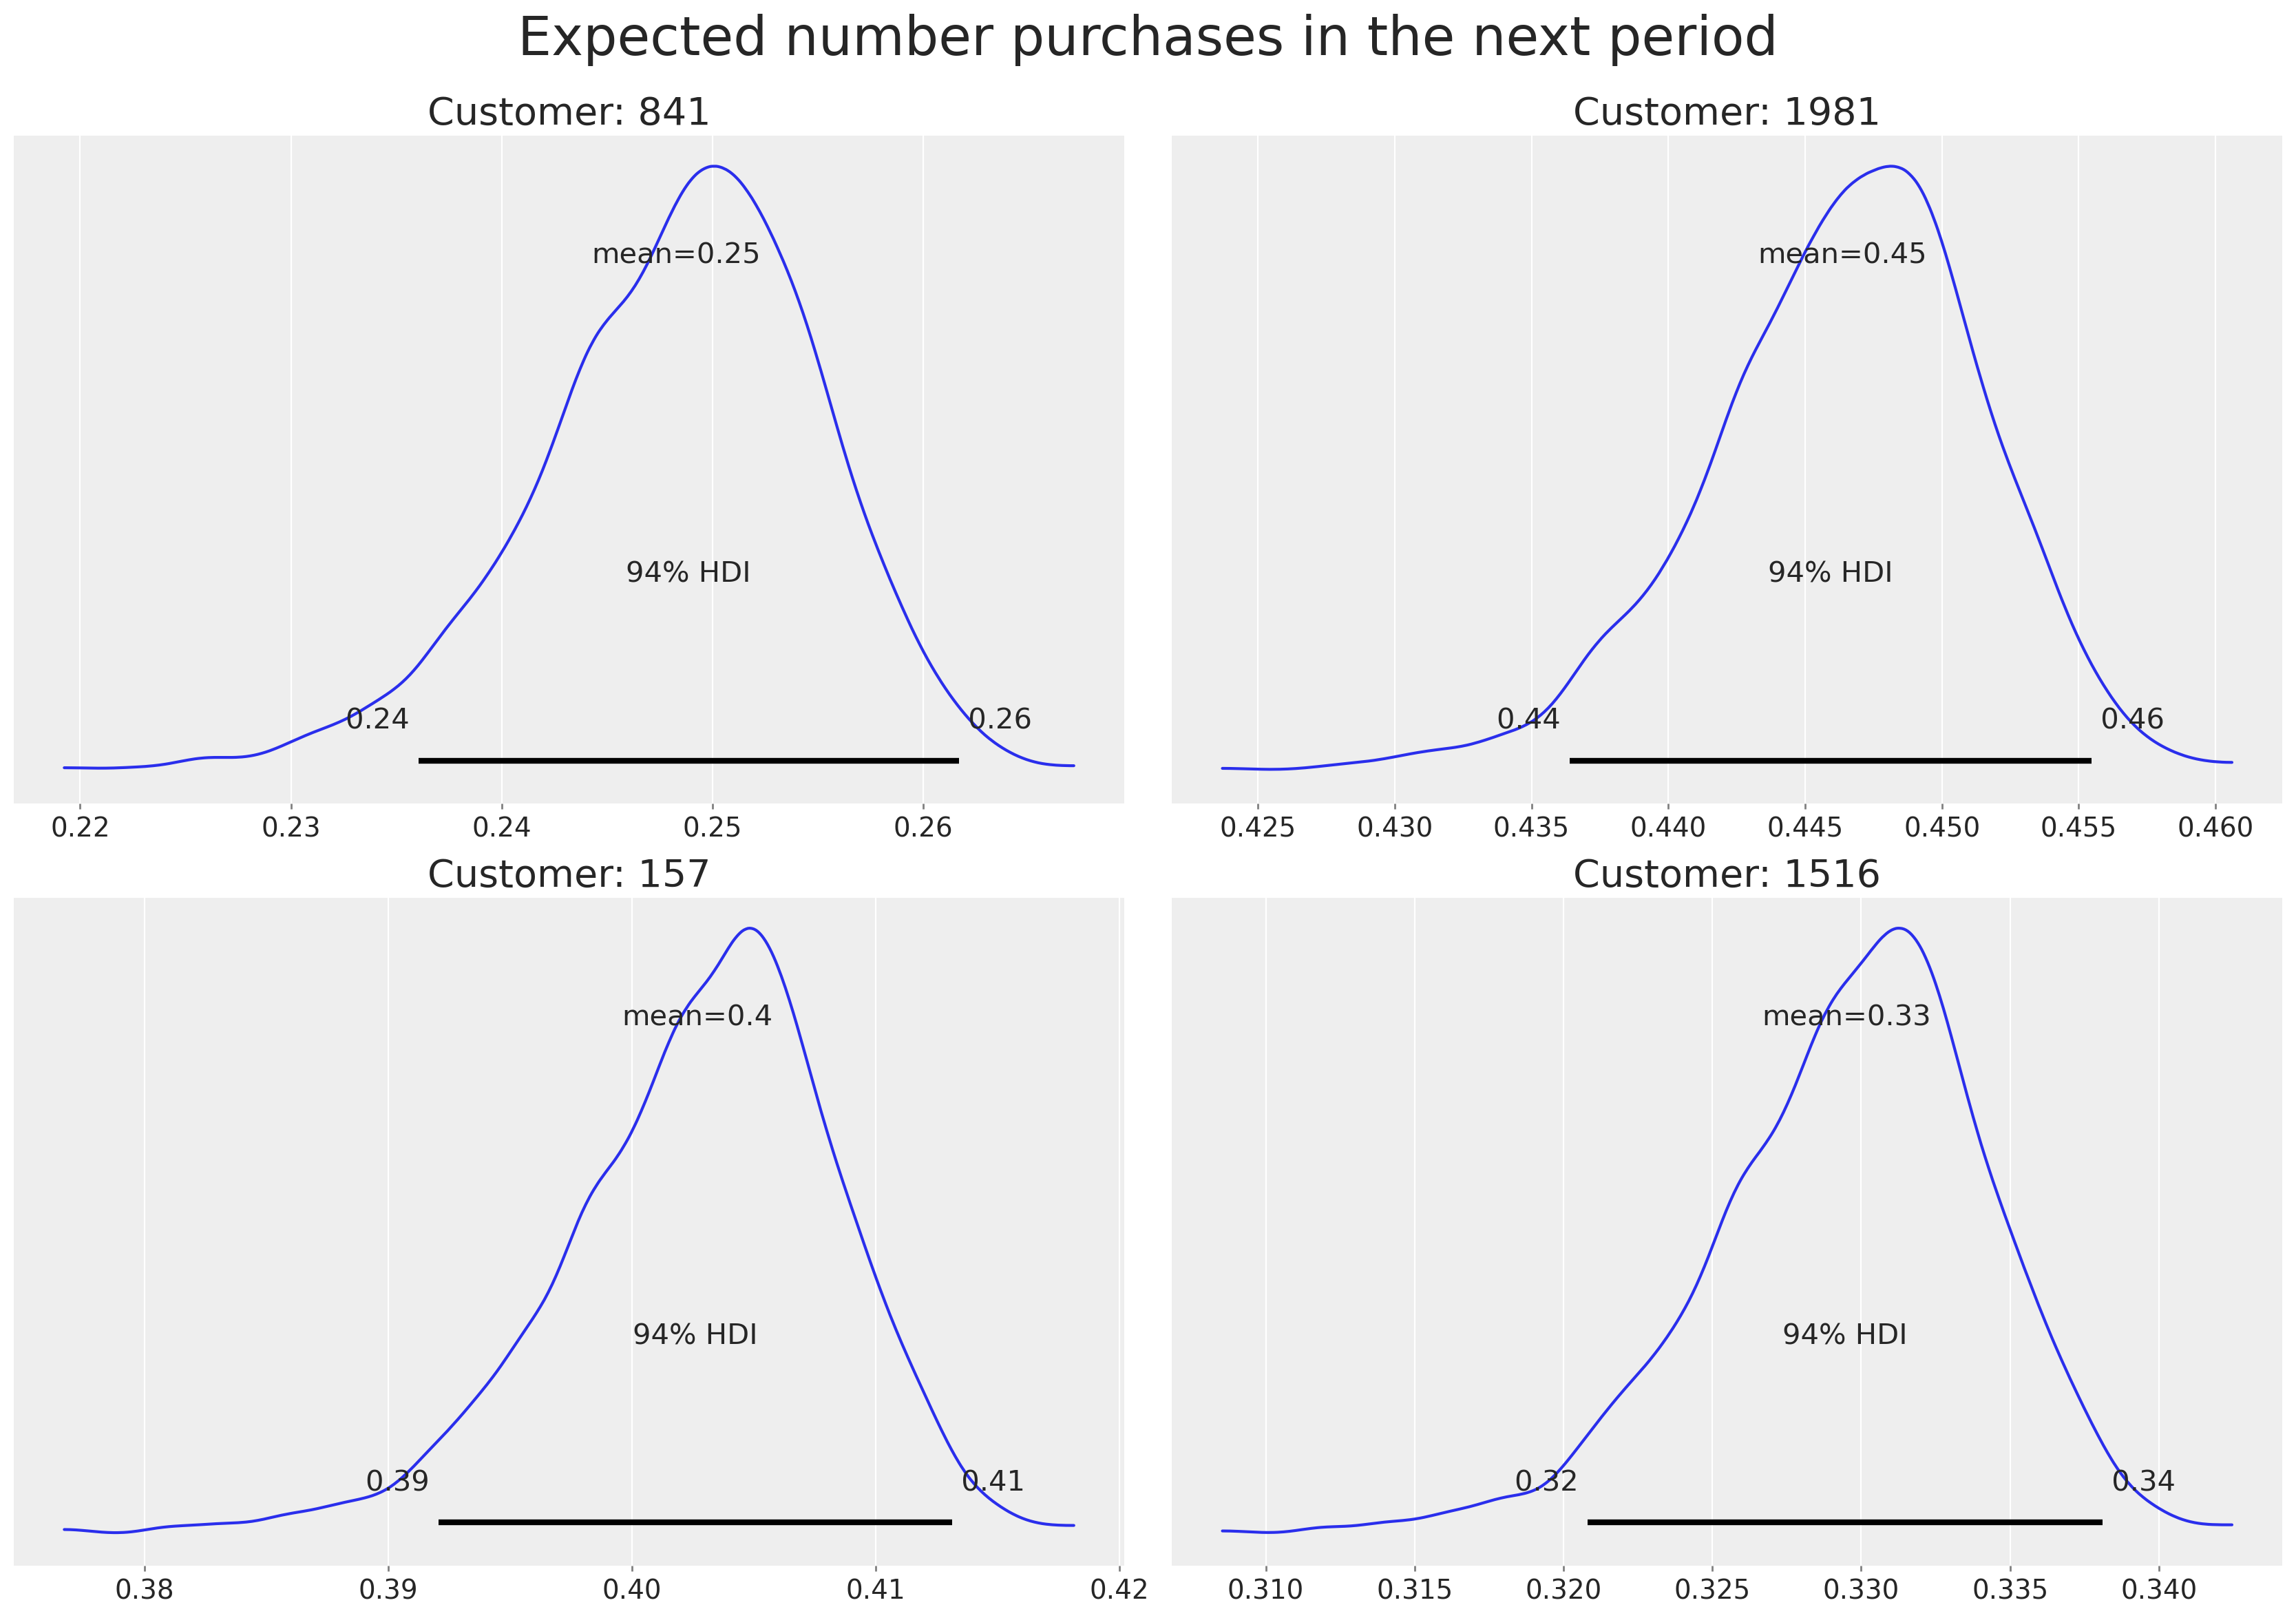

In [16]:
ids = [841, 1981, 157, 1516]
ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2))
for axi, id in zip(ax.ravel(), ids):
    axi.set_title(f"Customer: {id}", size=20)
plt.suptitle("Expected number purchases in the next period", fontsize=28, y=1.05)

# Predicting purchase behavior of a new customer

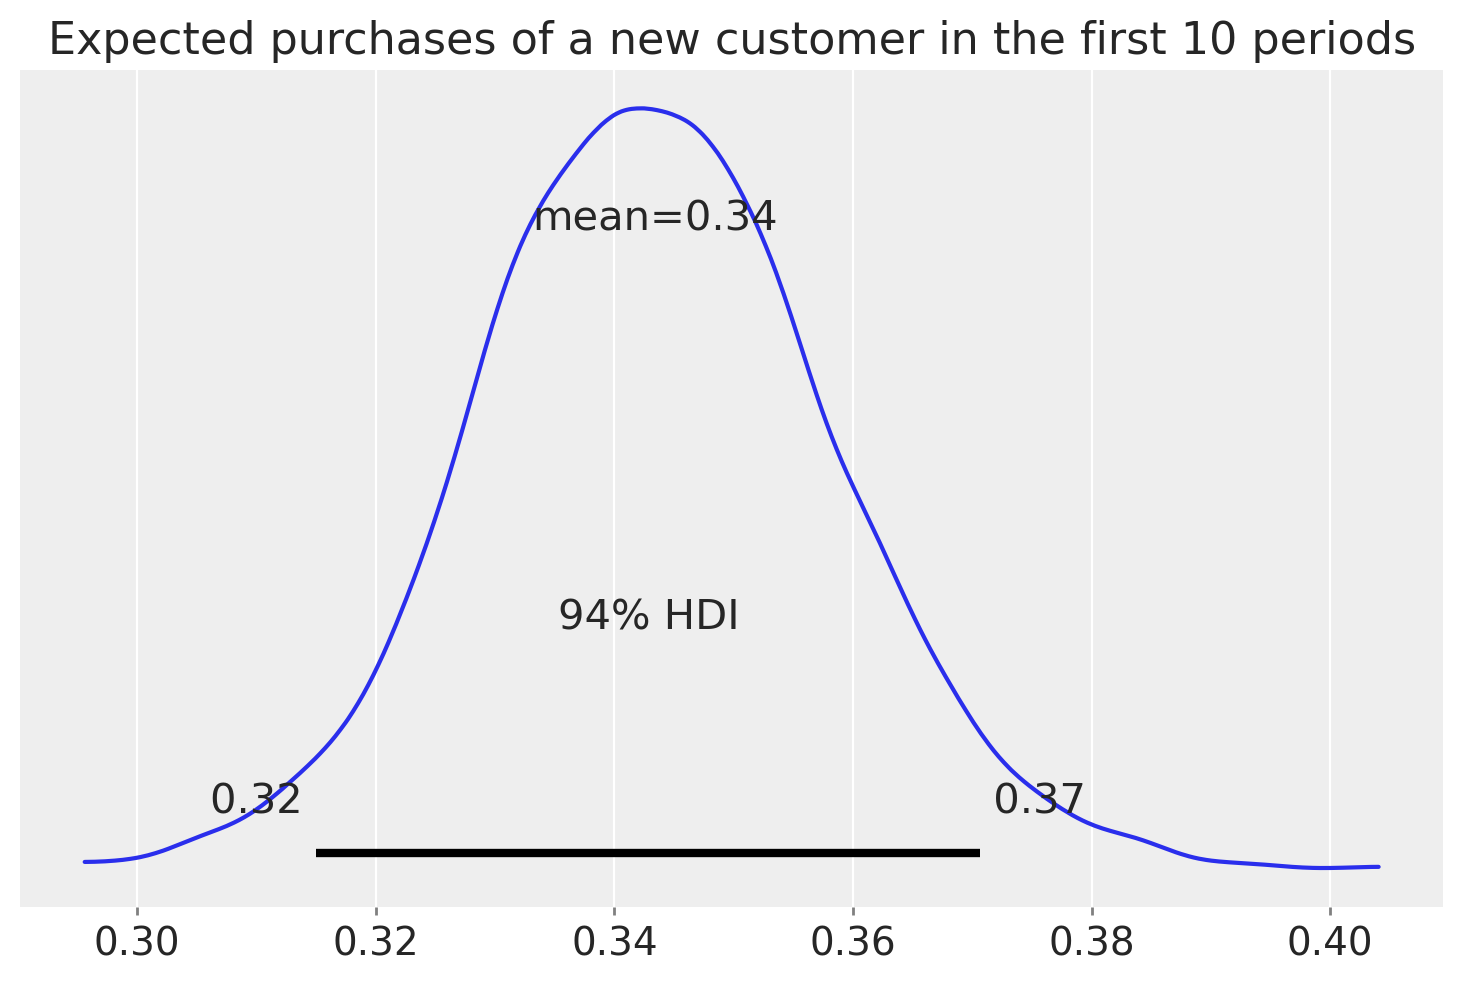

In [17]:
az.plot_posterior(
    bgm.expected_num_purchases_new_customer(t=10)
)
plt.title("Expected purchases of a new customer in the first 10 periods");


# Customer Probability Histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model.

Let look at active customer 1516 and assess the change in probability that the user will ever return if they do no other purchases in the next 9 time periods.

In [18]:
customer_1516 = rfm_data.loc[1515]
customer_1516

customer_id       1516.000000
frequency           27.000000
recency             67.000000
T                   70.000000
monetary_value      51.944074
Name: 1515, dtype: float64

In [19]:
customer_1516_history = pd.DataFrame(dict(
    ID=np.full(10, 1515, dtype="int"),
    frequency=np.full(10, customer_1516["frequency"], dtype="int"),
    recency=np.full(10, customer_1516["recency"]),
    T=(np.arange(0, 10) + customer_1516["recency"]).astype("int"),

))
customer_1516_history

,ID,frequency,recency,T
0,1515,27,67.0,67
1,1515,27,67.0,68
2,1515,27,67.0,69
3,1515,27,67.0,70
4,1515,27,67.0,71
5,1515,27,67.0,72
6,1515,27,67.0,73
7,1515,27,67.0,74
8,1515,27,67.0,75
9,1515,27,67.0,76


In [20]:
p_alive = bgm.expected_probability_alive(
    customer_id=customer_1516_history["ID"],
    frequency=customer_1516_history["frequency"],
    recency=customer_1516_history["recency"],
    T=customer_1516_history["T"],
)

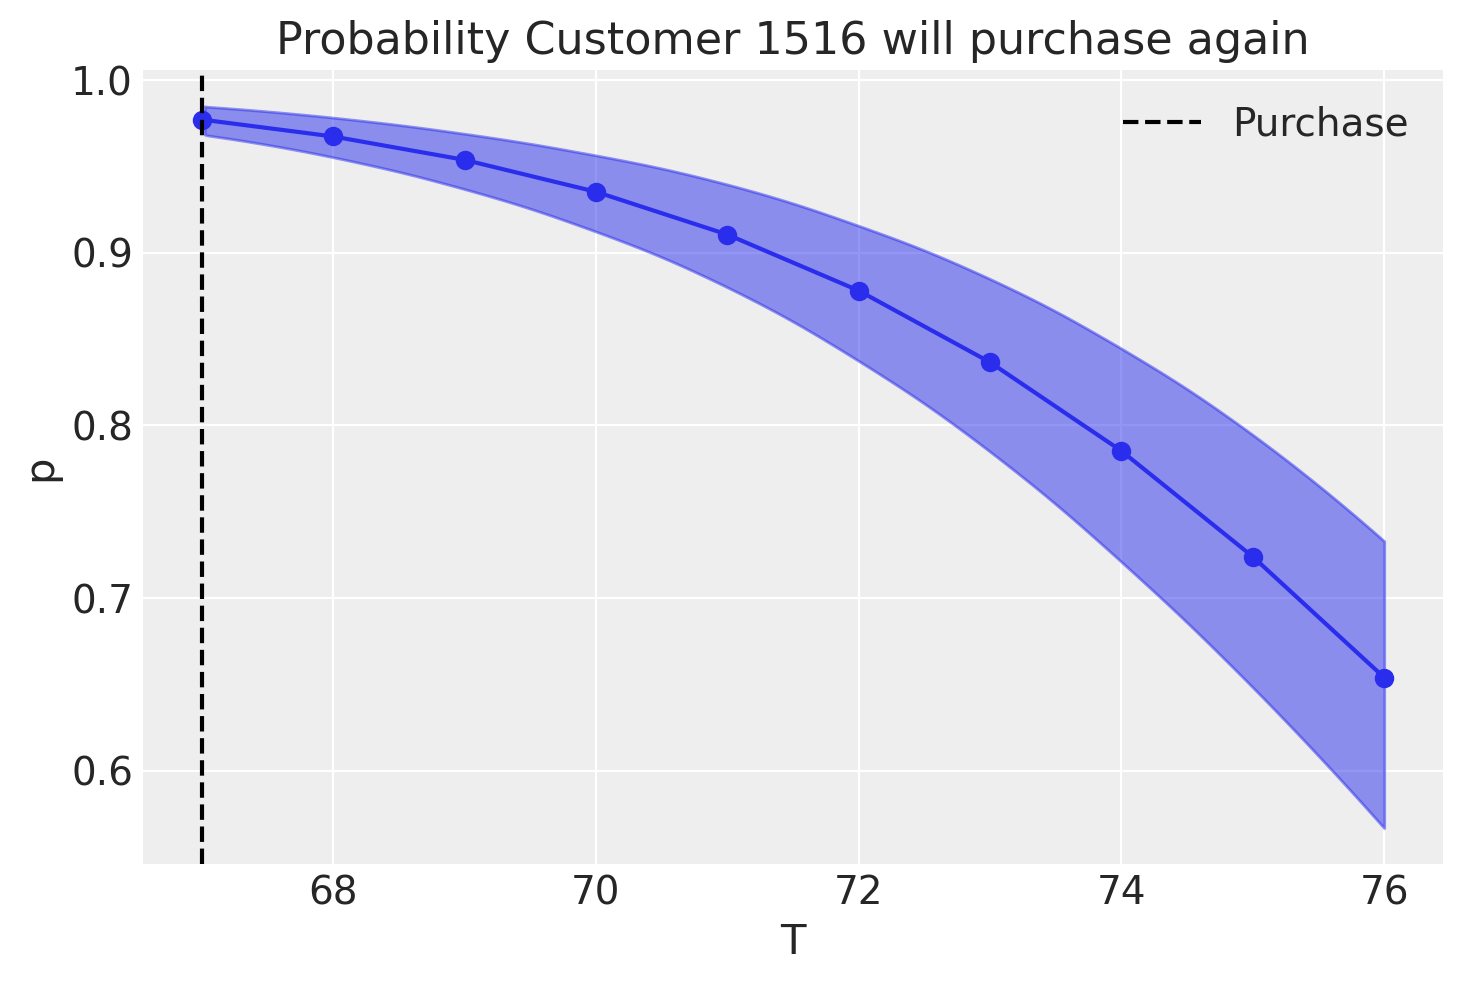

In [21]:
az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")
plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.title("Probability Customer 1516 will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend()

We can see that, if no purchases are being made in the next 9 weeks, the model has low confidence that the costumer will ever return. What if they had done one purchase in between?



In [22]:
customer_1516_history["frequency"].iloc[-3:] += 1
customer_1516_history["recency"].iloc[-3:] = customer_1516_history["T"].iloc[-3] - 0.5
customer_1516_history

,ID,frequency,recency,T
0,1515,27,67.0,67
1,1515,27,67.0,68
2,1515,27,67.0,69
3,1515,27,67.0,70
4,1515,27,67.0,71
5,1515,27,67.0,72
6,1515,27,67.0,73
7,1515,28,73.5,74
8,1515,28,73.5,75
9,1515,28,73.5,76


In [23]:
p_alive = bgm.expected_probability_alive(
    customer_id=customer_1516_history["ID"],
    frequency=customer_1516_history["frequency"],
    recency=customer_1516_history["recency"],
    T=customer_1516_history["T"],
)

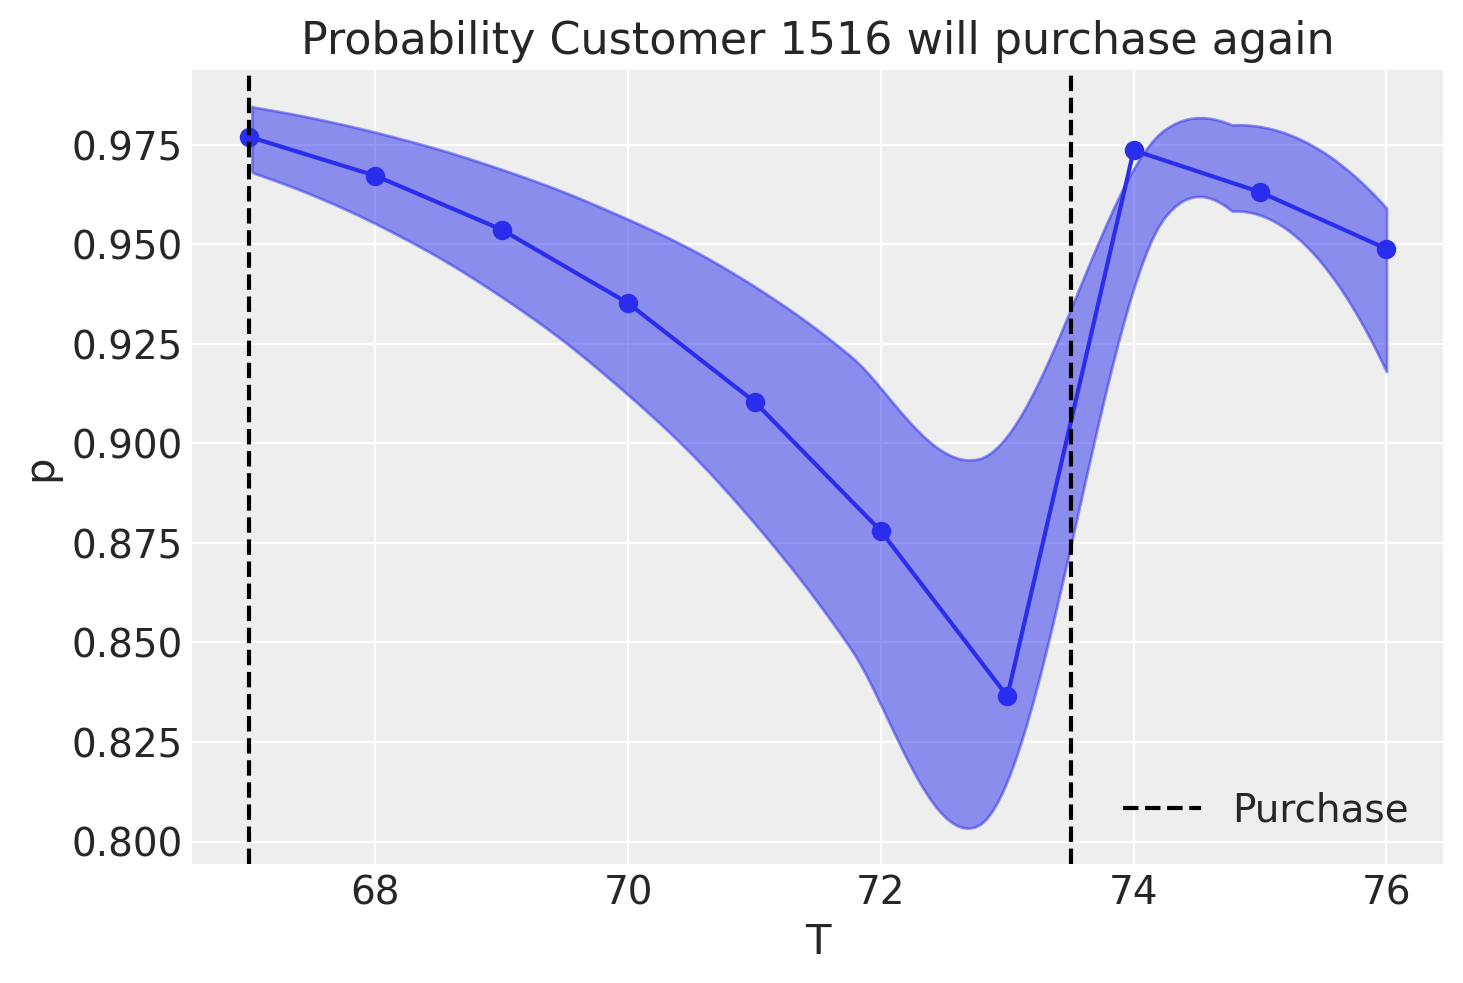

In [24]:
az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")
plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Purchase")
plt.axvline(customer_1516_history["recency"].iloc[-1], c="black", ls="--")

plt.title("Probability Customer 1516 will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend()

# Estimating Customer Lifetime Value Using the Gamma-Gamma Model

Until now we’ve focused mainly on transaction frequencies and probabilities, but to estimate economic value we can use the Gamma-Gamma model.

The Gamma-Gamma model assumes at least 1 repeat transaction has been observed per customer. As such we filter out those with zero repeat purchases.

In [25]:
nonzero_data = rfm_data.query("frequency>0")
nonzero_data

,customer_id,frequency,recency,T,monetary_value
0,1,3.0,49.0,78.0,23.723333
1,2,1.0,2.0,78.0,11.770000
5,6,14.0,76.0,78.0,76.503571
6,7,1.0,5.0,78.0,11.770000
7,8,1.0,61.0,78.0,26.760000
...,...,...,...,...,...
2351,2352,1.0,47.0,66.0,14.490000
2352,2353,2.0,53.0,66.0,19.775000
2353,2354,5.0,24.0,66.0,44.928000
2354,2355,1.0,44.0,66.0,24.600000


If computing the monetary value from your own data, note that it is the mean of a given customer’s value, not the sum. monetary_value can be used to represent profit, or revenue, or any value as long as it is consistently calculated for each customer.

The Gamma-Gamma model relies upon the important assumption there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation is less than 0.3:

In [26]:
nonzero_data[['monetary_value', 'frequency']].corr()


,monetary_value,frequency
monetary_value,1.000000,0.052819
frequency,0.052819,1.000000


Transaction frequencies and monetary values are uncorrelated; we can now fit our Gamma-Gamma model to predict average spend and expected lifetime values of our customers

The Gamma-Gamma model takes in a ‘data’ parameter, a pandas DataFrame with 3 columns representing Customer ID, average spend of repeat purchases, and number of repeat purchase for that customer. As with the BG/NBD model, these parameters are given HalfFlat priors which can be too diffuse for small datasets. For this example, we will use the default priors, but other priors can be specified just like with the BG/NBD example above.

In [27]:
dataset = pd.DataFrame({
    'customer_id': nonzero_data.index,
    'mean_transaction_value': nonzero_data["monetary_value"],
    'frequency': nonzero_data["frequency"],
})

In [28]:
gg = clv.GammaGammaModel(
    data = dataset
)
gg.build_model()
gg

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [29]:
gg.fit(fit_method="map")

Inference data with groups:
	> posterior
	> fit_data

In [30]:
gg.fit_summary()

p     4.785
q     3.882
v    22.653
Name: value, dtype: float64

In [31]:
gg.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

In [32]:
gg.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,4.801,0.760,3.498,6.215,0.026,0.019,806.0,1231.0,1.01
q,3.939,0.272,3.436,4.433,0.009,0.006,966.0,1697.0,1.00
v,23.751,5.211,14.671,33.916,0.192,0.136,754.0,1142.0,1.01


array([<Axes: title={'center': 'p'}>, <Axes: title={'center': 'q'}>,
       <Axes: title={'center': 'v'}>], dtype=object)

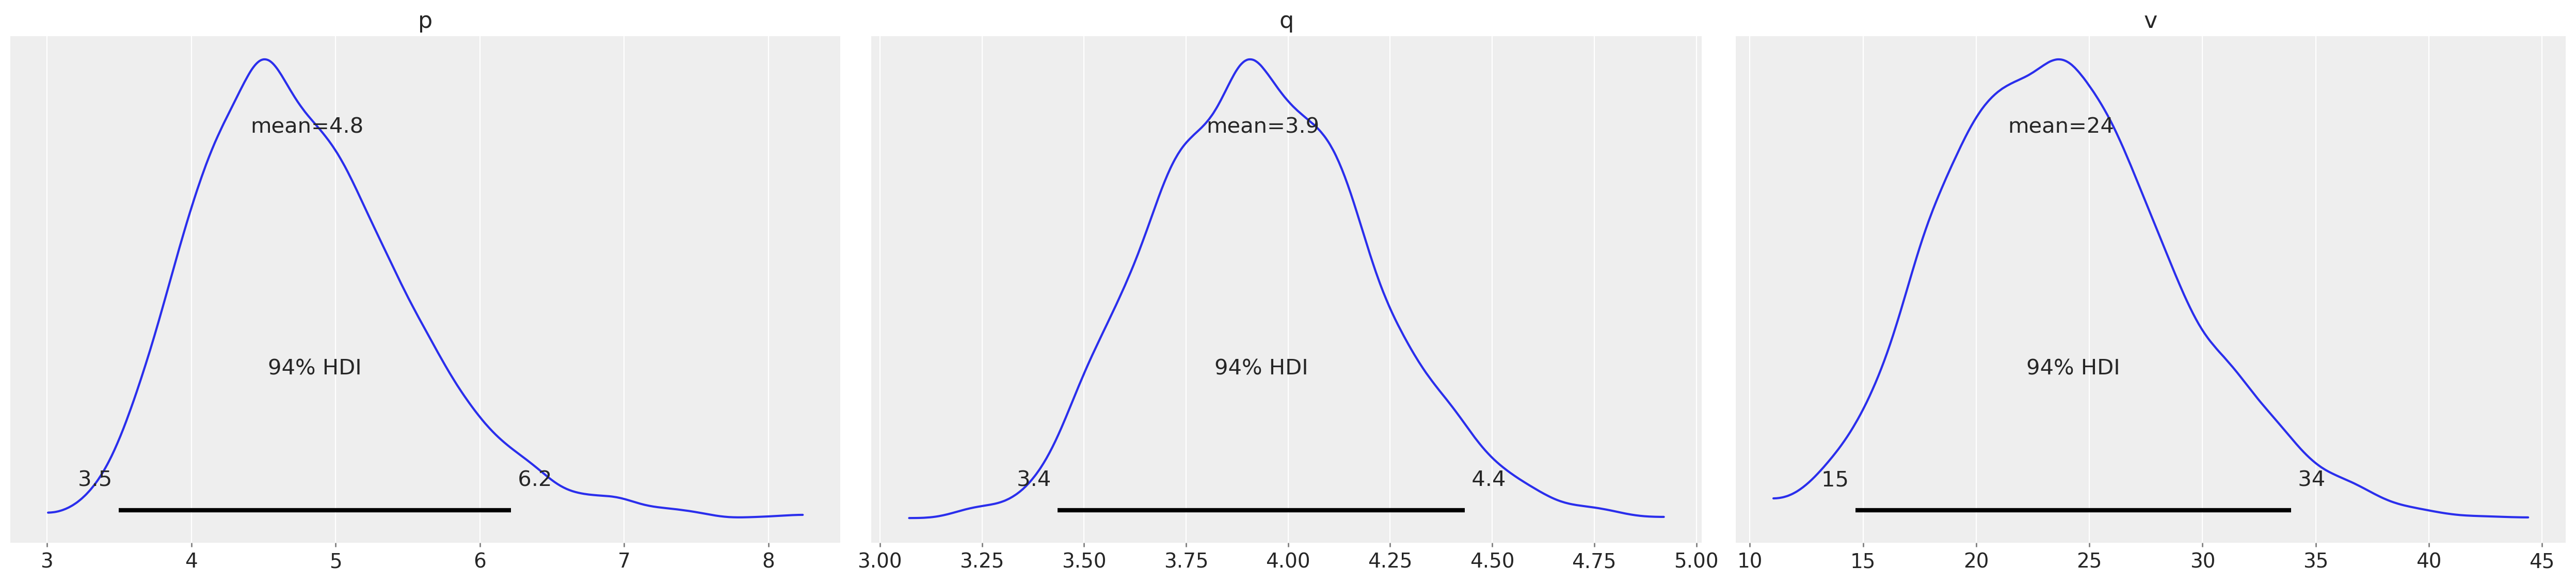

In [33]:
az.plot_posterior(gg.fit_result)

# Predicting spend value of customers

In [34]:
expected_spend = gg.expected_customer_spend(
    customer_id=rfm_data.index,
    mean_transaction_value=rfm_data["monetary_value"],
    frequency=rfm_data["frequency"],
)

In [35]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[0],26.116,0.442,25.343,27.008
x[1],21.650,1.342,19.247,24.234
x[2],37.585,0.860,36.011,39.219
x[3],37.585,0.860,36.011,39.219
x[4],37.585,0.860,36.011,39.219
x[5],74.824,0.362,74.072,75.427
x[6],21.650,1.342,19.247,24.234
x[7],30.899,0.614,29.808,32.115
x[8],36.427,0.150,36.145,36.701
x[9],37.585,0.860,36.011,39.219


Text(0.5, 0, 'Expected mean spend')

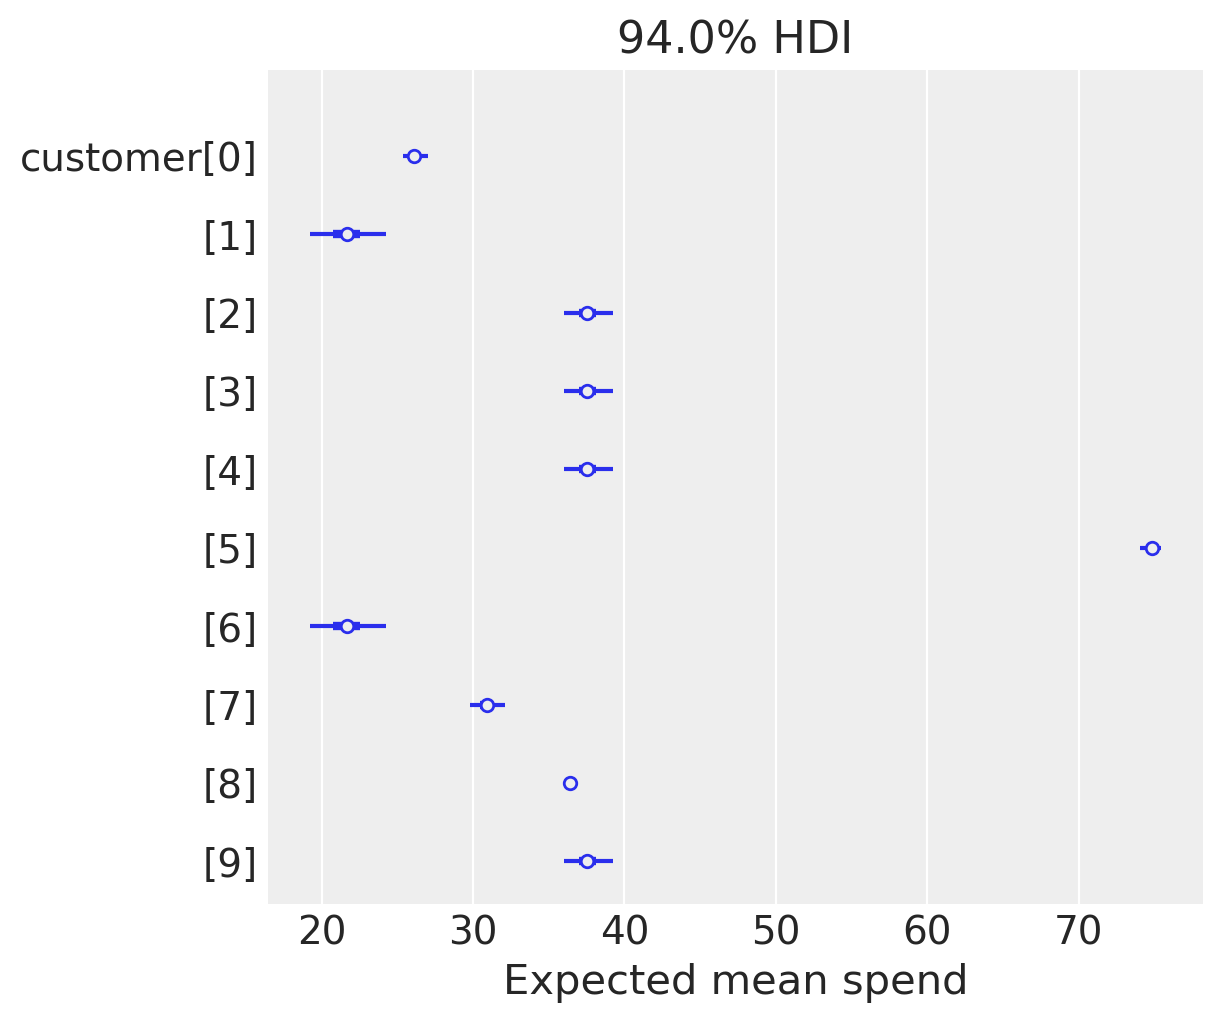

In [36]:
labeller = MapLabeller(var_name_map={"x": "customer"})
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True, labeller=labeller)
plt.xlabel("Expected mean spend")

We can also look at the average expected mean spend across all customers

In [38]:
az.summary(expected_spend.mean("customer_id"), kind="stats")


,mean,sd,hdi_3%,hdi_97%
x,37.982,0.543,36.977,39.005


Text(0.5, 1.0, 'Expected mean spend of all customers')

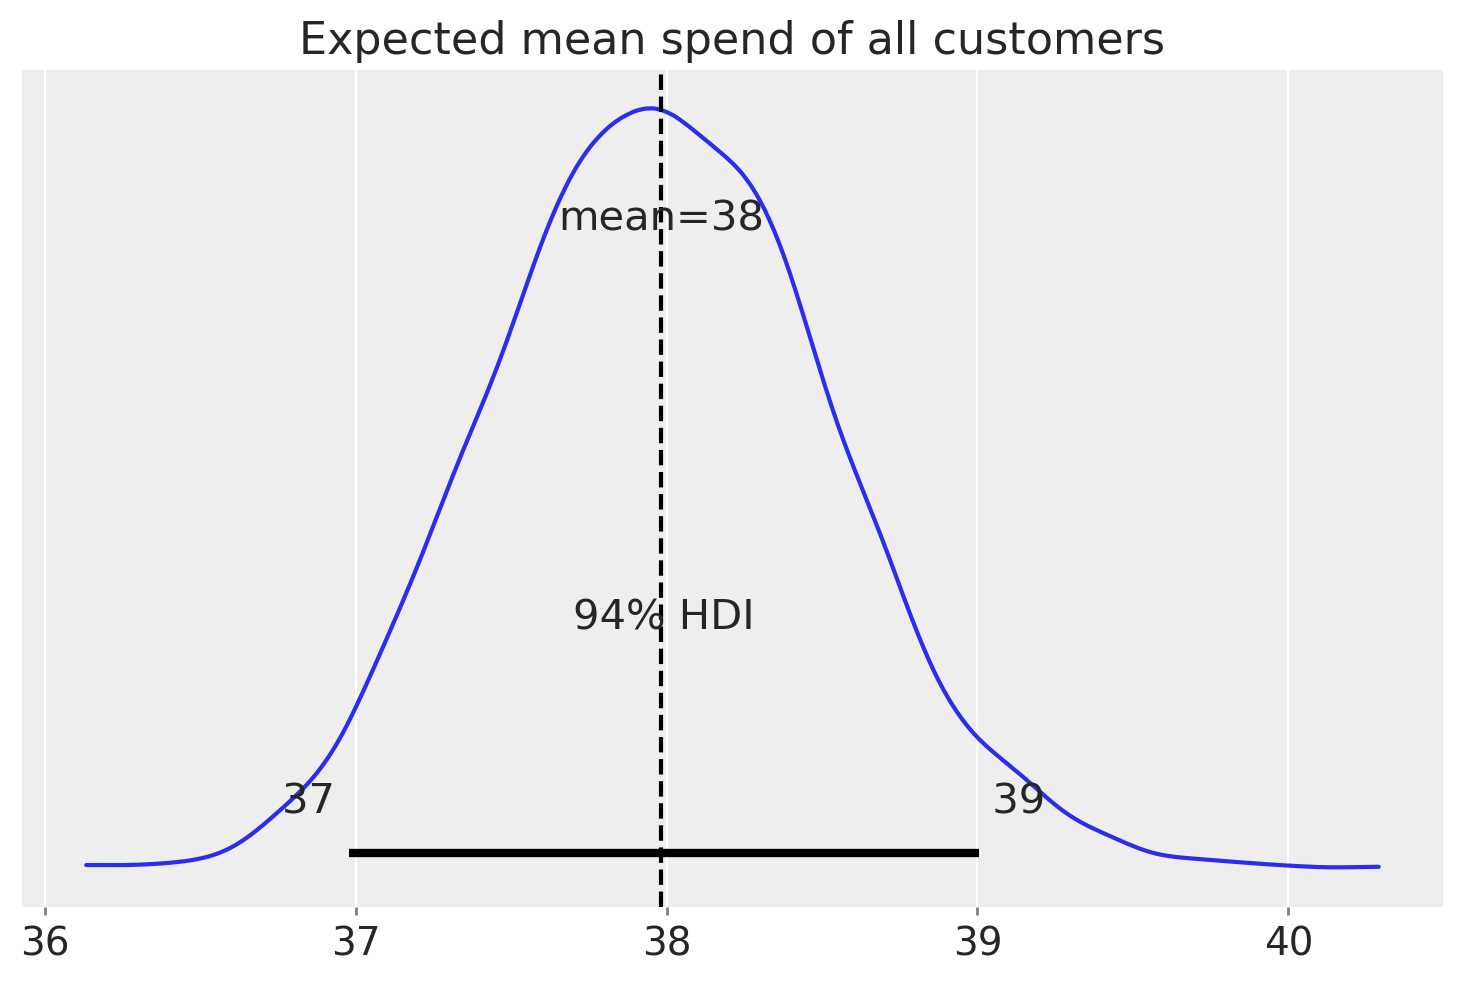

In [39]:
az.plot_posterior(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")
plt.title("Expected mean spend of all customers")

# Predicting spend value of a new customer

Text(0.5, 1.0, 'Expected mean spend of a new customer')

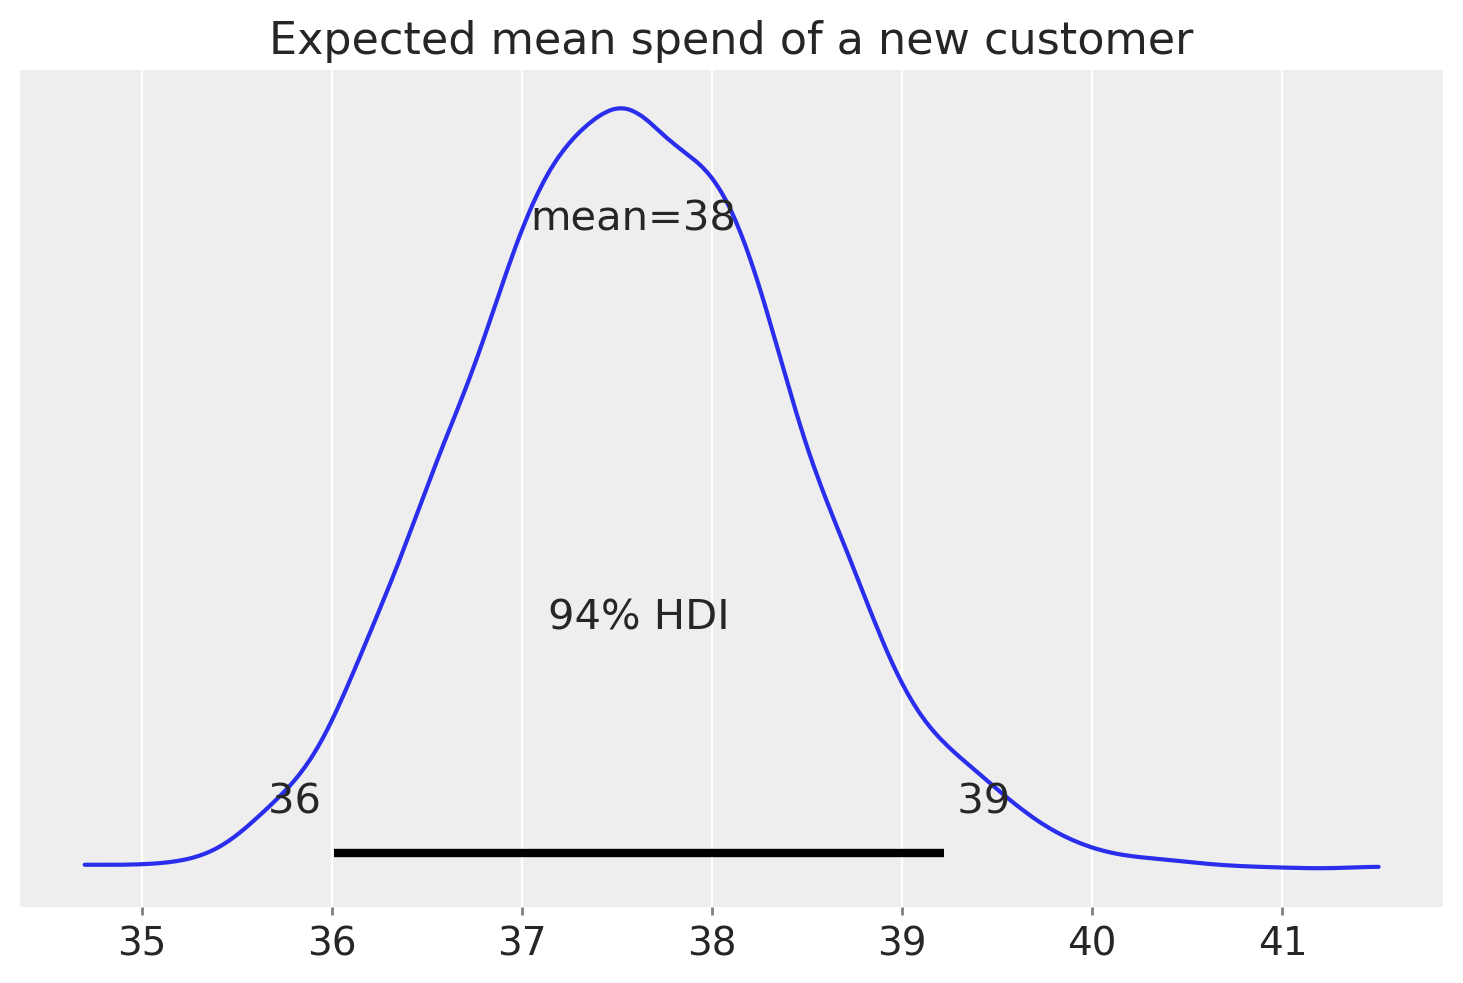

In [40]:
az.plot_posterior(
    gg.expected_new_customer_spend()
)
plt.title("Expected mean spend of a new customer")

# Estimating CLV

Finally, we can combine the GG with the BG/NBD model to obtain an estimate of the customer lifetime value. This relies on the Discounted cash flow model, adjusting for cost of capital:

In [41]:
clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    customer_id=rfm_data.index,
    mean_transaction_value=rfm_data["monetary_value"],
    frequency=rfm_data["frequency"],
    recency=rfm_data["recency"],
    T=rfm_data["T"],
    time=12, # months
    discount_rate=0.01, # monthly discount rate ~ 12.7% annually
    freq="W", # Our original data is in weeks
)

In [42]:
az.summary(clv_estimate.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[0],29.243,1.166,27.148,31.528
x[1],3.119,0.358,2.502,3.816
x[2],5.616,0.261,5.115,6.089
x[3],5.616,0.261,5.115,6.089
x[4],5.616,0.261,5.115,6.089
x[5],500.494,17.237,470.318,535.770
x[6],4.100,0.426,3.312,4.873
x[7],16.231,0.535,15.227,17.201
x[8],46.866,1.327,44.432,49.460
x[9],5.616,0.261,5.115,6.089


Text(0.5, 0, 'Expected CLV')

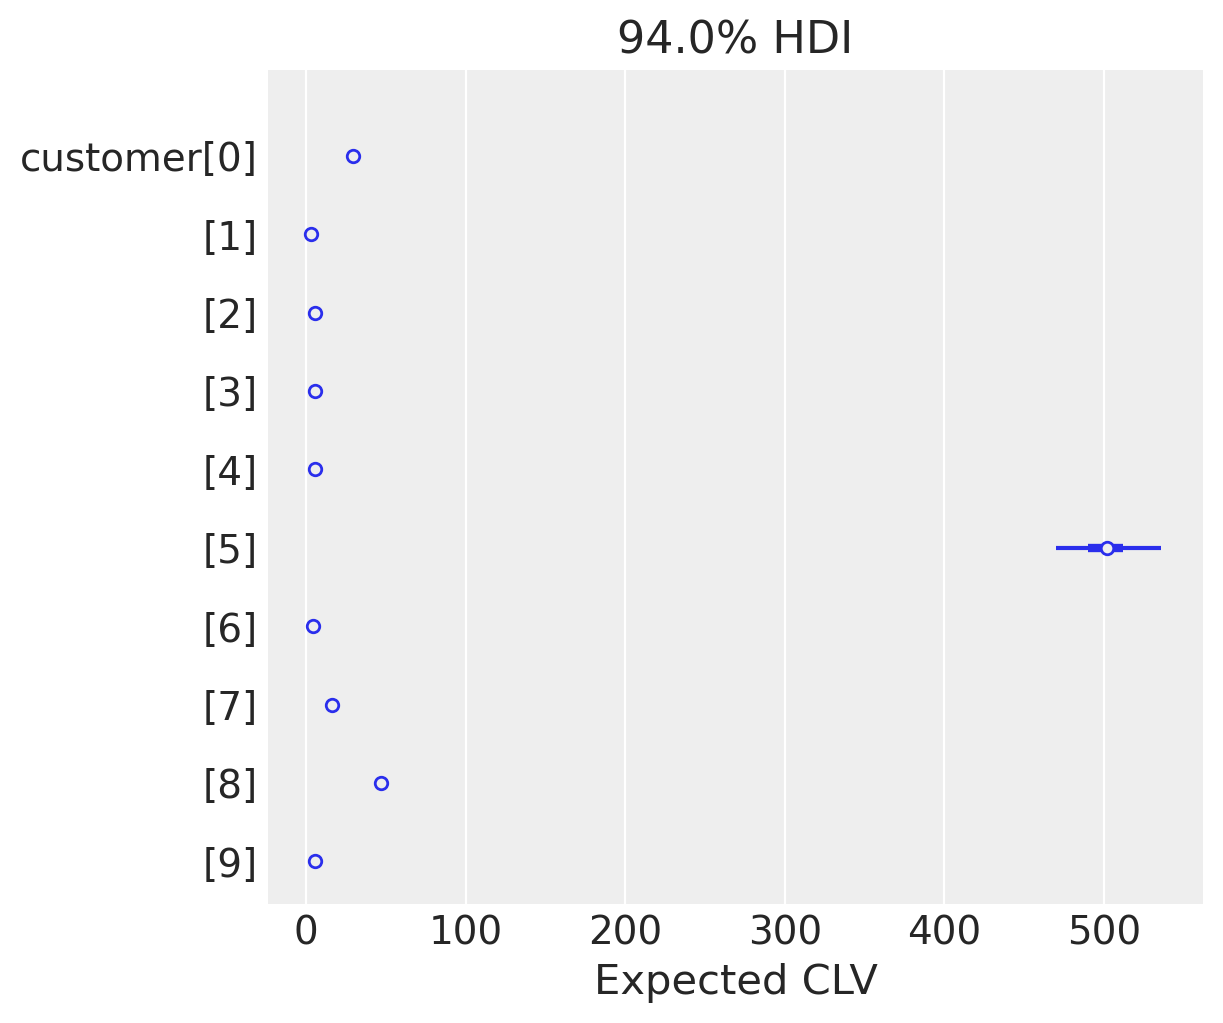

In [45]:
az.plot_forest(clv_estimate.isel(customer_id=range(10)), combined=True, labeller=labeller)
plt.xlabel("Expected CLV")

According to our models, customer 5 has a much higher expected CLV. There is also a large variability in this estimate that arises solely from uncertainty in the parameters of the BG/NBD and GG models.

In general, these models tend to induce a strong correlation between expected CLV and uncertainty. This modelling of uncertainty can be very useful when making marketing decisions.